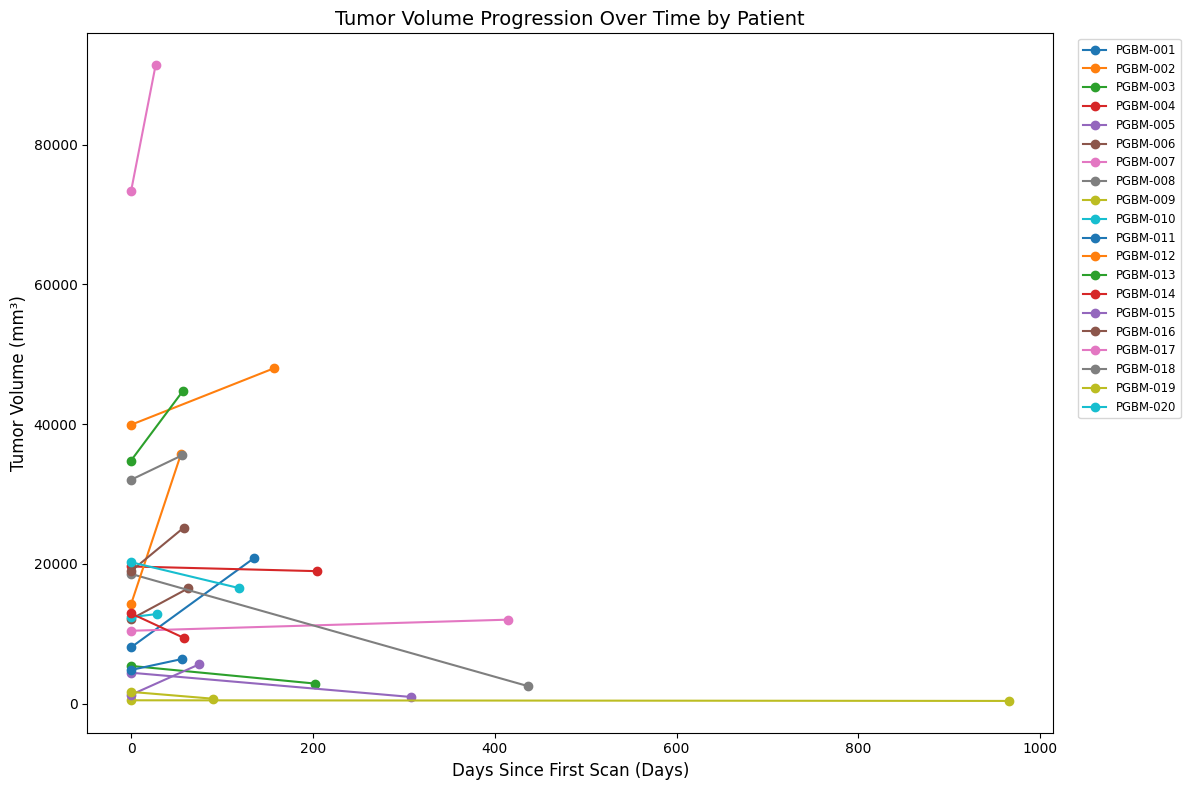

In [3]:
# Jupyter Notebook 또는 .py 스크립트 어디서나 바로 실행 가능합니다.

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from datetime import datetime

# ── 1) 경로 설정 ──
# (1) 전처리된 원본 마스크가 들어있는 루트 폴더
preproc_root = "/mnt/ssd/brain-tumor-prediction/data/btp_preproc_fixed22"
# (2) 등록된(FLIRT 후) 마스크가 들어있는 루트 폴더
#     → 부피 계산 자체는 원본 마스크로 하지만,
#        voxel 크기를 일관되게 얻기 위해 등록된 마스크의 헤더도 사용합니다.
reg_root     = "/mnt/ssd/brain-tumor-prediction/data/btp_reg_flirt_t1ce_fixed22_nostrip"

# ── 2) 환자별 데이터 수집 ──
# patient_data 딕셔너리 구조:
#   key: "PGBM-001" 등 환자ID
#   value: (days_list, volume_list)
#     days_list   : 첫 촬영일로부터 경과 일수 (int 리스트)
#     volume_list : 각 세션(날짜)에서 계산된 종양 부피 (float 리스트, 단위 mm³)
patient_data = {}

# reg_root 폴더 내 환자ID 반복
for patient_id in sorted(os.listdir(reg_root)):
    patient_reg_path = os.path.join(reg_root, patient_id)
    if not os.path.isdir(patient_reg_path):
        continue

    # “preproc_root”에도 동일한 patient_id 폴더가 있어야 함을 확인
    patient_preproc_path = os.path.join(preproc_root, patient_id)
    if not os.path.isdir(patient_preproc_path):
        # 만약 전처리 원본 폴더가 없으면 건너뛴다
        continue

    # ── (A) 세션(폴더명: 날짜) 목록 수집 ──
    #   각 세션 폴더명은 “YYYY-MM-DD” 형식이라고 가정
    sessions = []
    for sess_name in os.listdir(patient_preproc_path):
        sess_path = os.path.join(patient_preproc_path, sess_name)
        if not os.path.isdir(sess_path):
            continue
        try:
            sess_date = datetime.strptime(sess_name, "%Y-%m-%d")
            sessions.append((sess_date, sess_name))
        except ValueError:
            # “YYYY-MM-DD” 포맷이 아니면 건너뛴다
            continue

    if len(sessions) == 0:
        # 날짜형 세션이 하나도 없으면 건너뛴다
        continue

    # 날짜 오름차순 정렬
    sessions.sort(key=lambda x: x[0])
    first_date = sessions[0][0]

    days_list = []
    volume_list = []

    # ── (B) 각 세션별로 원본 마스크 파일을 읽어서 부피 계산 ──
    for date_obj, date_str in sessions:
        # 1) 첫 촬영일 대비 경과 일수
        delta_days = (date_obj - first_date).days
        days_list.append(delta_days)

        # 2) 원본 마스크 파일 경로 (전처리 폴더)
        orig_mask_path = os.path.join(preproc_root, patient_id, date_str, "mask.nii.gz")
        if not os.path.exists(orig_mask_path):
            # 원본 마스크가 없으면 부피 계산 불가 → 0으로 처리하거나 건너뛸 수 있다
            # 여기서는 “0” 부피로 둔다. (건너뛰고 싶으면 continue)
            volume_list.append(0.0)
            continue

        # 3) NIfTI 로드 (원본 마스크)
        orig_mask_nii = nib.load(orig_mask_path)
        orig_mask_data = orig_mask_nii.get_fdata()

        # 4) voxel 크기(mm) 계산: 등록된 마스크에서 뽑자
        #    (원본 헤더에 slice thickness 이나 zooms 정보가 
        #      reg_root에도 동일하므로, reg mask 헤더를 사용해도 무방)
        reg_mask_path = os.path.join(reg_root, patient_id, date_str, "mask2fixed_affine.nii.gz")
        if os.path.exists(reg_mask_path):
            reg_mask_nii = nib.load(reg_mask_path)
            vx, vy, vz = reg_mask_nii.header.get_zooms()[:3]
        else:
            # 만약 등록된 마스크 헤더가 없다면, 원본 헤더에서 가져온다
            vx, vy, vz = orig_mask_nii.header.get_zooms()[:3]
        voxel_volume = vx * vy * vz  # mm³

        # 5) 종양 영역(=1 또는 >0) voxel 수 세기
        #    (마스크가 이진(binary) 형태라 가정: 0/1 혹은 0/ >0)
        tumor_voxel_count = np.count_nonzero(orig_mask_data)

        # 6) 전체 종양 부피 계산
        tumor_volume = tumor_voxel_count * voxel_volume  # mm³
        volume_list.append(tumor_volume)

    # days_list와 volume_list 길이가 같아야 유효하므로, 확인 후 저장
    if len(days_list) == len(volume_list):
        patient_data[patient_id] = (days_list, volume_list)


# ── 3) 모든 환자 한 그래프에 그리기 ──
plt.figure(figsize=(12, 8))

for pid, (days, vols) in patient_data.items():
    plt.plot(days, vols, marker='o', label=pid)

plt.xlabel("Days Since First Scan (Days)", fontsize=12)
plt.ylabel("Tumor Volume (mm³)", fontsize=12)
plt.title("Tumor Volume Progression Over Time by Patient", fontsize=14)

# 범례를 오른쪽에 크게 표시
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small', ncol=1)

plt.tight_layout()
plt.show()


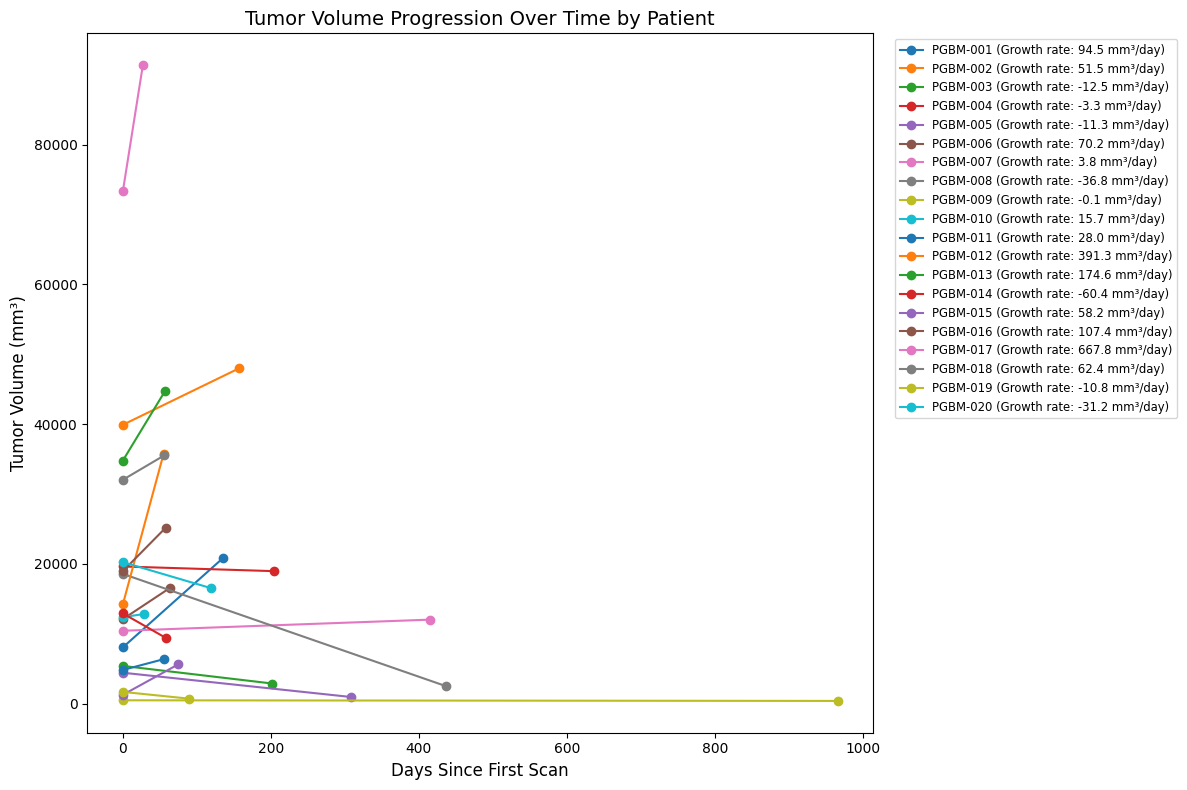

In [5]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from datetime import datetime

# ── 1) Path settings ──
preproc_root = "/mnt/ssd/brain-tumor-prediction/data/btp_preproc_fixed22"
reg_root     = "/mnt/ssd/brain-tumor-prediction/data/btp_reg_flirt_t1ce_fixed22_nostrip"

# ── 2) Collect per-patient data ──
# Structure:
#   patient_data[patient_id] = (days_list, volume_list, growth_rate)
patient_data = {}

for patient_id in sorted(os.listdir(reg_root)):
    patient_reg_path = os.path.join(reg_root, patient_id)
    if not os.path.isdir(patient_reg_path):
        continue

    patient_preproc_path = os.path.join(preproc_root, patient_id)
    if not os.path.isdir(patient_preproc_path):
        continue

    # Gather all session folders named "YYYY-MM-DD"
    sessions = []
    for sess_name in os.listdir(patient_preproc_path):
        sess_path = os.path.join(patient_preproc_path, sess_name)
        if not os.path.isdir(sess_path):
            continue
        try:
            sess_date = datetime.strptime(sess_name, "%Y-%m-%d")
            sessions.append((sess_date, sess_name))
        except ValueError:
            continue

    if len(sessions) == 0:
        continue

    # Sort sessions by date
    sessions.sort(key=lambda x: x[0])
    first_date = sessions[0][0]

    days_list = []
    volume_list = []

    # For each session, load the original mask and compute volume
    for date_obj, date_str in sessions:
        # 1) Days since first scan
        delta_days = (date_obj - first_date).days
        days_list.append(delta_days)

        # 2) Path to the original mask in preprocessed folder
        orig_mask_path = os.path.join(
            preproc_root, patient_id, date_str, "mask.nii.gz"
        )
        if not os.path.exists(orig_mask_path):
            volume_list.append(0.0)
            continue

        # 3) Load the original mask
        orig_mask_nii = nib.load(orig_mask_path)
        orig_mask_data = orig_mask_nii.get_fdata()

        # 4) Determine voxel size (mm³) using registered mask header if available
        reg_mask_path = os.path.join(
            reg_root, patient_id, date_str, "mask2fixed_affine.nii.gz"
        )
        if os.path.exists(reg_mask_path):
            reg_mask_nii = nib.load(reg_mask_path)
            vx, vy, vz = reg_mask_nii.header.get_zooms()[:3]
        else:
            vx, vy, vz = orig_mask_nii.header.get_zooms()[:3]
        voxel_volume = vx * vy * vz  # mm³ per voxel

        # 5) Count nonzero voxels
        tumor_voxel_count = np.count_nonzero(orig_mask_data)

        # 6) Compute tumor volume
        tumor_volume = tumor_voxel_count * voxel_volume
        volume_list.append(tumor_volume)

    # Compute average growth rate (last minus first) / (time span)
    if len(days_list) > 1:
        total_days = days_list[-1] - days_list[0]
        total_vol_change = volume_list[-1] - volume_list[0]
        growth_rate = total_vol_change / total_days if total_days != 0 else 0.0
    else:
        growth_rate = 0.0

    patient_data[patient_id] = (days_list, volume_list, growth_rate)

# ── 3) Plot all patients on a single figure ──
plt.figure(figsize=(12, 8))

for pid, (days, vols, rate) in patient_data.items():
    label_str = f"{pid} (Growth rate: {rate:.1f} mm³/day)"
    plt.plot(days, vols, marker='o', label=label_str)

plt.xlabel("Days Since First Scan", fontsize=12)
plt.ylabel("Tumor Volume (mm³)", fontsize=12)
plt.title("Tumor Volume Progression Over Time by Patient", fontsize=14)

# Place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()


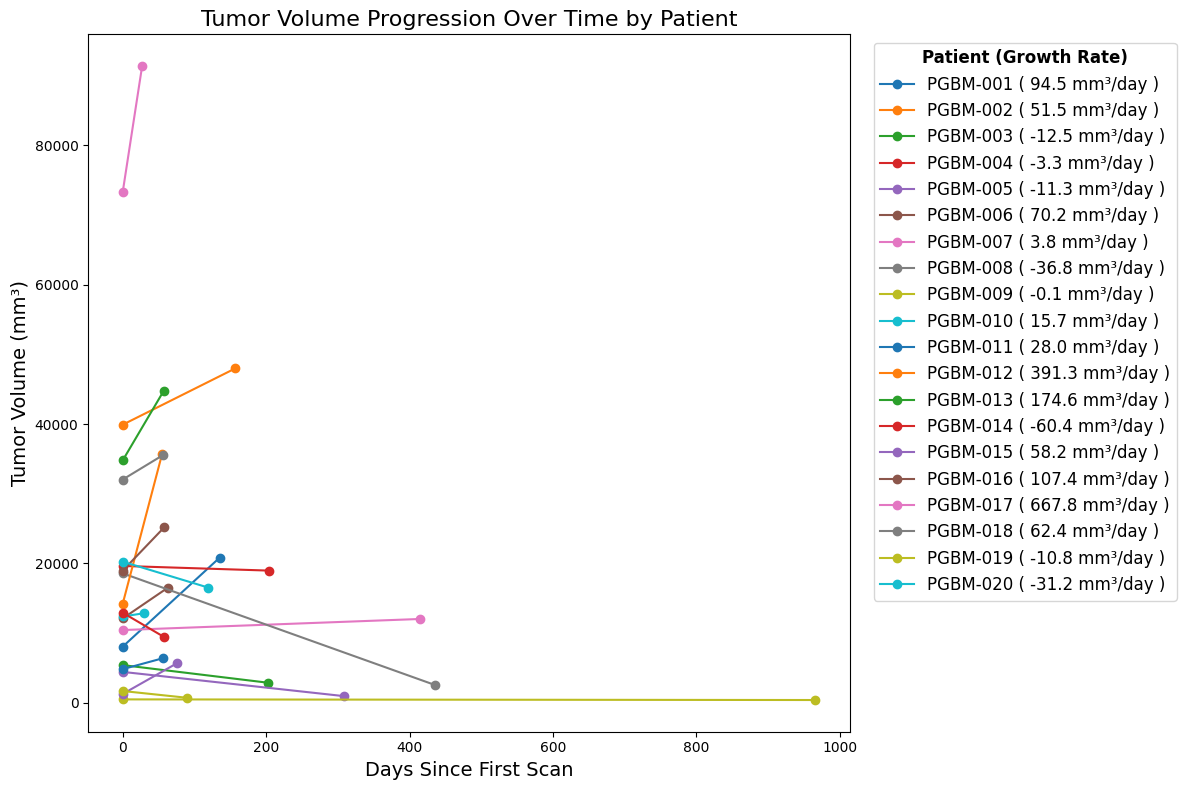

In [10]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from datetime import datetime

# ── 1) Path settings ──
preproc_root = "/mnt/ssd/brain-tumor-prediction/data/btp_preproc_fixed22"
reg_root     = "/mnt/ssd/brain-tumor-prediction/data/btp_reg_flirt_t1ce_fixed22_nostrip"

# ── 2) Collect per‐patient data ──
# Structure:
#   patient_data[patient_id] = (days_list, volume_list, growth_rate)
patient_data = {}

for patient_id in sorted(os.listdir(reg_root)):
    patient_reg_path = os.path.join(reg_root, patient_id)
    if not os.path.isdir(patient_reg_path):
        continue

    patient_preproc_path = os.path.join(preproc_root, patient_id)
    if not os.path.isdir(patient_preproc_path):
        continue

    # Gather all session folders named "YYYY-MM-DD"
    sessions = []
    for sess_name in os.listdir(patient_preproc_path):
        sess_path = os.path.join(patient_preproc_path, sess_name)
        if not os.path.isdir(sess_path):
            continue
        try:
            sess_date = datetime.strptime(sess_name, "%Y-%m-%d")
            sessions.append((sess_date, sess_name))
        except ValueError:
            continue

    if len(sessions) == 0:
        continue

    # Sort sessions by date
    sessions.sort(key=lambda x: x[0])
    first_date = sessions[0][0]

    days_list = []
    volume_list = []

    # For each session, load the original mask and compute volume
    for date_obj, date_str in sessions:
        # 1) Days since first scan
        delta_days = (date_obj - first_date).days
        days_list.append(delta_days)

        # 2) Path to the original mask in preprocessed folder
        orig_mask_path = os.path.join(
            preproc_root, patient_id, date_str, "mask.nii.gz"
        )
        if not os.path.exists(orig_mask_path):
            volume_list.append(0.0)
            continue

        # 3) Load the original mask
        orig_mask_nii = nib.load(orig_mask_path)
        orig_mask_data = orig_mask_nii.get_fdata()

        # 4) Determine voxel size (mm³) using registered mask header if available
        reg_mask_path = os.path.join(
            reg_root, patient_id, date_str, "mask2fixed_affine.nii.gz"
        )
        if os.path.exists(reg_mask_path):
            reg_mask_nii = nib.load(reg_mask_path)
            vx, vy, vz = reg_mask_nii.header.get_zooms()[:3]
        else:
            vx, vy, vz = orig_mask_nii.header.get_zooms()[:3]
        voxel_volume = vx * vy * vz  # mm³ per voxel

        # 5) Count nonzero voxels
        tumor_voxel_count = np.count_nonzero(orig_mask_data)

        # 6) Compute tumor volume
        tumor_volume = tumor_voxel_count * voxel_volume
        volume_list.append(tumor_volume)

    # Compute average growth rate (last minus first) / (time span)
    if len(days_list) > 1:
        total_days = days_list[-1] - days_list[0]
        total_vol_change = volume_list[-1] - volume_list[0]
        growth_rate = total_vol_change / total_days if total_days != 0 else 0.0
    else:
        growth_rate = 0.0

    patient_data[patient_id] = (days_list, volume_list, growth_rate)

# ── 3) Plot all patients on a single figure ──
plt.figure(figsize=(12, 8))

for pid, (days, vols, rate) in patient_data.items():
    label_str = f"{pid} ( {rate:.1f} mm³/day )"
    plt.plot(days, vols, marker='o', label=label_str)

plt.xlabel("Days Since First Scan", fontsize=14)
plt.ylabel("Tumor Volume (mm³)", fontsize=14)
plt.title("Tumor Volume Progression Over Time by Patient", fontsize=16)

# Increase legend font size so Patient ID and rate stand out
legend = plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=12,         # larger font size for legend entries
    title="Patient (Growth Rate)", 
    title_fontsize=12    # legend title font size
)

# Optionally make legend title bold
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()


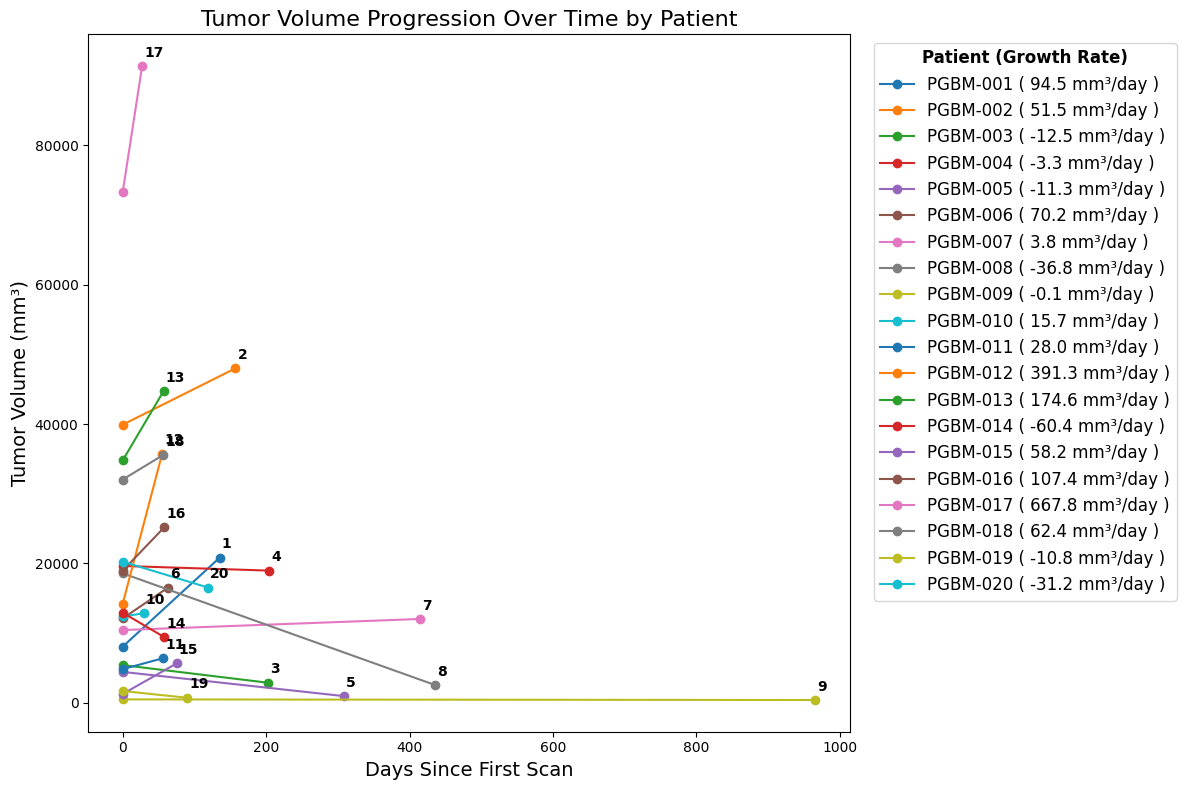

In [15]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from datetime import datetime

# ── 1) Path settings ──
preproc_root = "/mnt/ssd/brain-tumor-prediction/data/btp_preproc_fixed22"
reg_root     = "/mnt/ssd/brain-tumor-prediction/data/btp_reg_flirt_t1ce_fixed22_nostrip"

# ── 2) Collect per‐patient data ──
# Structure:
#   patient_data[patient_id] = (days_list, volume_list, growth_rate)
patient_data = {}

for patient_id in sorted(os.listdir(reg_root)):
    patient_reg_path = os.path.join(reg_root, patient_id)
    if not os.path.isdir(patient_reg_path):
        continue

    patient_preproc_path = os.path.join(preproc_root, patient_id)
    if not os.path.isdir(patient_preproc_path):
        continue

    # Gather all session folders named "YYYY-MM-DD"
    sessions = []
    for sess_name in os.listdir(patient_preproc_path):
        sess_path = os.path.join(patient_preproc_path, sess_name)
        if not os.path.isdir(sess_path):
            continue
        try:
            sess_date = datetime.strptime(sess_name, "%Y-%m-%d")
            sessions.append((sess_date, sess_name))
        except ValueError:
            continue

    if len(sessions) == 0:
        continue

    # Sort sessions by date
    sessions.sort(key=lambda x: x[0])
    first_date = sessions[0][0]

    days_list = []
    volume_list = []

    # For each session, load the original mask and compute volume
    for date_obj, date_str in sessions:
        # 1) Days since first scan
        delta_days = (date_obj - first_date).days
        days_list.append(delta_days)

        # 2) Path to the original mask in preprocessed folder
        orig_mask_path = os.path.join(
            preproc_root, patient_id, date_str, "mask.nii.gz"
        )
        if not os.path.exists(orig_mask_path):
            volume_list.append(0.0)
            continue

        # 3) Load the original mask
        orig_mask_nii = nib.load(orig_mask_path)
        orig_mask_data = orig_mask_nii.get_fdata()

        # 4) Determine voxel size (mm³) using registered mask header if available
        reg_mask_path = os.path.join(
            reg_root, patient_id, date_str, "mask2fixed_affine.nii.gz"
        )
        if os.path.exists(reg_mask_path):
            reg_mask_nii = nib.load(reg_mask_path)
            vx, vy, vz = reg_mask_nii.header.get_zooms()[:3]
        else:
            vx, vy, vz = orig_mask_nii.header.get_zooms()[:3]
        voxel_volume = vx * vy * vz  # mm³ per voxel

        # 5) Count nonzero voxels
        tumor_voxel_count = np.count_nonzero(orig_mask_data)

        # 6) Compute tumor volume
        tumor_volume = tumor_voxel_count * voxel_volume
        volume_list.append(tumor_volume)

    # Compute average growth rate (last minus first) / (time span)
    if len(days_list) > 1:
        total_days = days_list[-1] - days_list[0]
        total_vol_change = volume_list[-1] - volume_list[0]
        growth_rate = total_vol_change / total_days if total_days != 0 else 0.0
    else:
        growth_rate = 0.0

    patient_data[patient_id] = (days_list, volume_list, growth_rate)

# ── 3) Plot all patients on a single figure ──
plt.figure(figsize=(12, 8))

# 모든 환자의 부피 값을 모아서 전체 범위를 구해두면, 번호 표시 시 y축 오프셋을 일정 비율로 줄 때 편리합니다.
all_vols = np.hstack([vols for (_, (__, vols, ___)) in patient_data.items()])
vol_range = all_vols.max() - all_vols.min() if all_vols.size > 0 else 1.0

# enumerate() 를 사용해서 1부터 순서를 매깁니다.
for idx, (pid, (days, vols, rate)) in enumerate(patient_data.items(), start=1):
    # 1) 각 환자 곡선 그리기
    label_str = f"{pid} ( {rate:.1f} mm³/day )"
    plt.plot(days, vols, marker='o', label=label_str)

    # 2) 곡선의 마지막 점 좌표
    x_last = days[-1]
    y_last = vols[-1]

    # 3) 마지막 점 옆에 번호(idx) 를 찍어 줍니다.
    #    x축으로는 +3 (days 단위), y축으로는 전체 부피 범위의 1% 만큼 올려서 겹치지 않도록 합니다.
    plt.text(
        x_last + 3,
        y_last + 0.01 * vol_range,
        str(idx),
        fontsize=10,
        fontweight='bold',
        color='black',
        ha='left',
        va='bottom'
    )

# 4) 레이블, 타이틀, 범례 그대로 유지
plt.xlabel("Days Since First Scan", fontsize=14)
plt.ylabel("Tumor Volume (mm³)", fontsize=14)
plt.title("Tumor Volume Progression Over Time by Patient", fontsize=16)

legend = plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=12,         # 범례 폰트 크기
    title="Patient (Growth Rate)", 
    title_fontsize=12    # 범례 제목 폰트 크기
)
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()


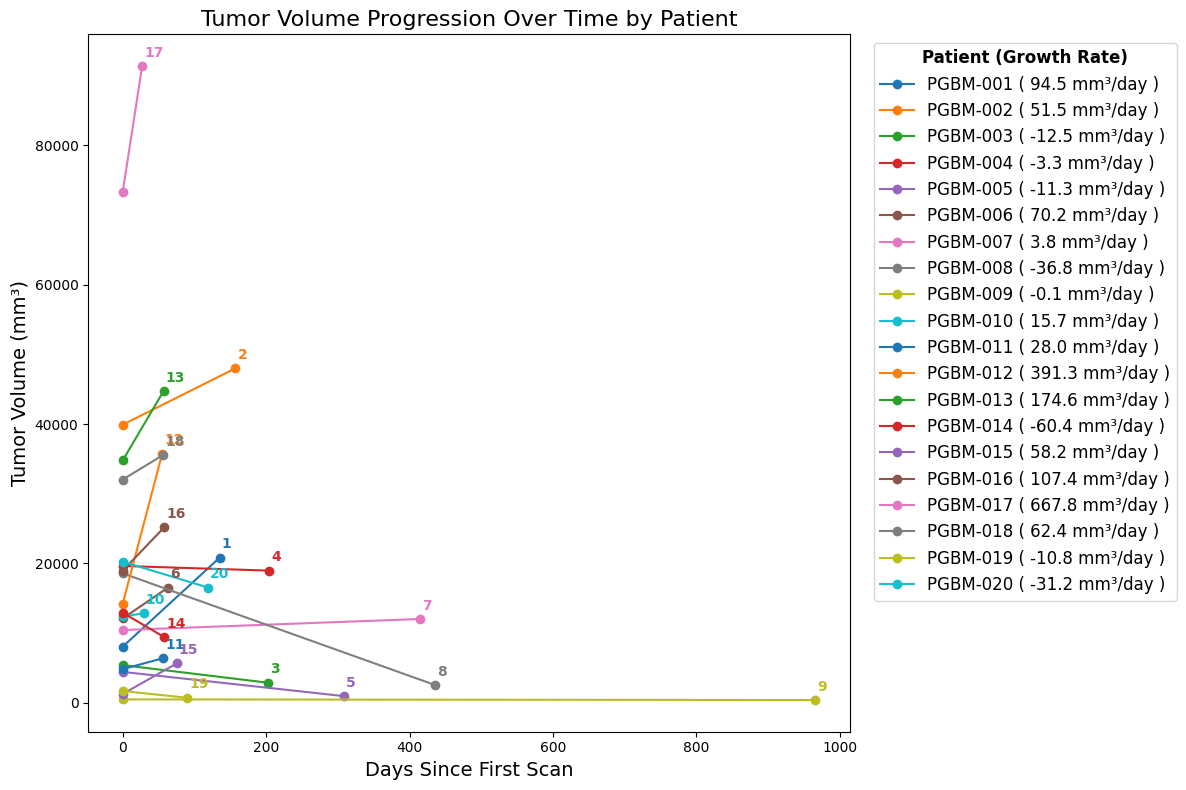

In [16]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from datetime import datetime

# ── 1) Path settings ──
preproc_root = "/mnt/ssd/brain-tumor-prediction/data/btp_preproc_fixed22"
reg_root     = "/mnt/ssd/brain-tumor-prediction/data/btp_reg_flirt_t1ce_fixed22_nostrip"

# ── 2) Collect per‐patient data ──
# Structure:
#   patient_data[patient_id] = (days_list, volume_list, growth_rate)
patient_data = {}

for patient_id in sorted(os.listdir(reg_root)):
    patient_reg_path = os.path.join(reg_root, patient_id)
    if not os.path.isdir(patient_reg_path):
        continue

    patient_preproc_path = os.path.join(preproc_root, patient_id)
    if not os.path.isdir(patient_preproc_path):
        continue

    # Gather all session folders named "YYYY-MM-DD"
    sessions = []
    for sess_name in os.listdir(patient_preproc_path):
        sess_path = os.path.join(patient_preproc_path, sess_name)
        if not os.path.isdir(sess_path):
            continue
        try:
            sess_date = datetime.strptime(sess_name, "%Y-%m-%d")
            sessions.append((sess_date, sess_name))
        except ValueError:
            continue

    if len(sessions) == 0:
        continue

    # Sort sessions by date
    sessions.sort(key=lambda x: x[0])
    first_date = sessions[0][0]

    days_list = []
    volume_list = []

    # For each session, load the original mask and compute volume
    for date_obj, date_str in sessions:
        # 1) Days since first scan
        delta_days = (date_obj - first_date).days
        days_list.append(delta_days)

        # 2) Path to the original mask in preprocessed folder
        orig_mask_path = os.path.join(
            preproc_root, patient_id, date_str, "mask.nii.gz"
        )
        if not os.path.exists(orig_mask_path):
            volume_list.append(0.0)
            continue

        # 3) Load the original mask
        orig_mask_nii = nib.load(orig_mask_path)
        orig_mask_data = orig_mask_nii.get_fdata()

        # 4) Determine voxel size (mm³) using registered mask header if available
        reg_mask_path = os.path.join(
            reg_root, patient_id, date_str, "mask2fixed_affine.nii.gz"
        )
        if os.path.exists(reg_mask_path):
            reg_mask_nii = nib.load(reg_mask_path)
            vx, vy, vz = reg_mask_nii.header.get_zooms()[:3]
        else:
            vx, vy, vz = orig_mask_nii.header.get_zooms()[:3]
        voxel_volume = vx * vy * vz  # mm³ per voxel

        # 5) Count nonzero voxels
        tumor_voxel_count = np.count_nonzero(orig_mask_data)

        # 6) Compute tumor volume
        tumor_volume = tumor_voxel_count * voxel_volume
        volume_list.append(tumor_volume)

    # Compute average growth rate (last minus first) / (time span)
    if len(days_list) > 1:
        total_days = days_list[-1] - days_list[0]
        total_vol_change = volume_list[-1] - volume_list[0]
        growth_rate = total_vol_change / total_days if total_days != 0 else 0.0
    else:
        growth_rate = 0.0

    patient_data[patient_id] = (days_list, volume_list, growth_rate)

# ── 3) Plot all patients on a single figure ──
plt.figure(figsize=(12, 8))

# 모든 환자의 부피 값을 모아서 전체 범위를 구해둡니다.
all_vols = np.hstack([
    volumes for (_, (__, volumes, ___)) in patient_data.items()
]) if patient_data else np.array([0.0])
vol_range = all_vols.max() - all_vols.min() if all_vols.size > 1 else 1.0

# enumerate() 로 1부터 순서를 매깁니다.
for idx, (pid, (days, vols, rate)) in enumerate(patient_data.items(), start=1):
    # 1) 각 환자 곡선을 그리고, 반환된 Line2D 객체에서 색상을 가져옵니다.
    label_str = f"{pid} ( {rate:.1f} mm³/day )"
    line_obj, = plt.plot(days, vols, marker='o', label=label_str)
    line_color = line_obj.get_color()

    # 2) 해당 곡선의 마지막 점 좌표
    x_last = days[-1]
    y_last = vols[-1]

    # 3) 마지막 점 옆에 idx 번호를 line_color 와 동일하게 표시합니다.
    plt.text(
        x_last + 3,
        y_last + 0.01 * vol_range,
        str(idx),
        fontsize=10,
        fontweight='bold',
        color=line_color,  # 곡선과 동일한 색깔 지정
        ha='left',
        va='bottom'
    )

# 4) 레이블, 타이틀, 범례는 그대로 유지
plt.xlabel("Days Since First Scan", fontsize=14)
plt.ylabel("Tumor Volume (mm³)", fontsize=14)
plt.title("Tumor Volume Progression Over Time by Patient", fontsize=16)

legend = plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=12,         # 범례 폰트 크기
    title="Patient (Growth Rate)", 
    title_fontsize=12    # 범례 제목 폰트 크기
)
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()


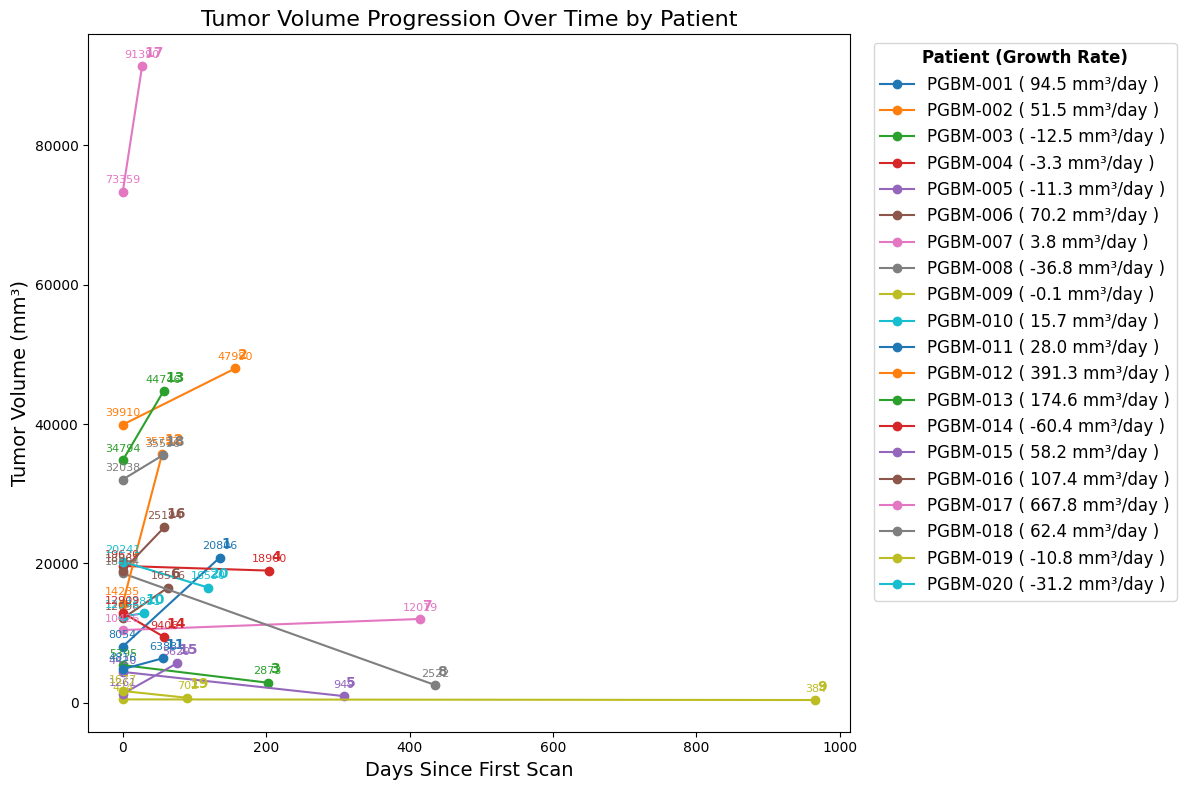

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from datetime import datetime

# ── 1) Path settings ──
preproc_root = "/mnt/ssd/brain-tumor-prediction/data/btp_preproc_fixed22"
reg_root     = "/mnt/ssd/brain-tumor-prediction/data/btp_reg_flirt_t1ce_fixed22_nostrip"

# ── 2) Collect per‐patient data ──
patient_data = {}
for patient_id in sorted(os.listdir(reg_root)):
    p_reg = os.path.join(reg_root, patient_id)
    p_pre = os.path.join(preproc_root, patient_id)
    if not os.path.isdir(p_reg) or not os.path.isdir(p_pre):
        continue

    # Gather session dates
    sessions = []
    for d in os.listdir(p_pre):
        p_d = os.path.join(p_pre, d)
        if os.path.isdir(p_d):
            try:
                dt = datetime.strptime(d, "%Y-%m-%d")
                sessions.append((dt, d))
            except ValueError:
                pass
    if not sessions:
        continue

    # Sort & baseline
    sessions.sort(key=lambda x: x[0])
    first_date = sessions[0][0]

    days_list = []
    volume_list = []
    for (dt, d) in sessions:
        days = (dt - first_date).days
        days_list.append(days)

        mask_path = os.path.join(p_pre, d, "mask.nii.gz")
        if not os.path.exists(mask_path):
            volume_list.append(0.0)
            continue

        # load mask
        m = nib.load(mask_path)
        data = m.get_fdata()
        # get voxel size from registered mask if present
        reg_mask = os.path.join(p_reg, d, "mask2fixed_affine.nii.gz")
        if os.path.exists(reg_mask):
            r = nib.load(reg_mask)
            vx, vy, vz = r.header.get_zooms()[:3]
        else:
            vx, vy, vz = m.header.get_zooms()[:3]
        voxel_vol = vx * vy * vz

        vol = np.count_nonzero(data) * voxel_vol
        volume_list.append(vol)

    # compute growth rate
    if len(days_list) > 1:
        tot_days = days_list[-1] - days_list[0]
        tot_vol = volume_list[-1] - volume_list[0]
        rate = tot_vol / tot_days if tot_days else 0.0
    else:
        rate = 0.0

    patient_data[patient_id] = (days_list, volume_list, rate)

# ── 3) Plot ──
plt.figure(figsize=(12, 8))

# 전체 부피 범위 계산 (annotation offset 용)
all_vols = np.hstack([vols for (_, (_, vols, _)) in patient_data.items()]) if patient_data else np.array([0.0])
vmin, vmax = all_vols.min(), all_vols.max()
vspan = vmax - vmin if vmax > vmin else 1.0

for idx, (pid, (days, vols, rate)) in enumerate(patient_data.items(), start=1):
    # plot line
    lbl = f"{pid} ( {rate:.1f} mm³/day )"
    line, = plt.plot(days, vols, marker='o', label=lbl)
    color = line.get_color()

    # annotate each point with its volume value
    for x, y in zip(days, vols):
        plt.text(
            x, y + 0.01 * vspan,
            f"{y:.0f}",
            color=color,
            fontsize=8,
            ha='center',
            va='bottom'
        )

    # annotate end with index number
    x_last, y_last = days[-1], vols[-1]
    plt.text(
        x_last + 3, y_last + 0.01 * vspan,
        str(idx),
        color=color,
        fontsize=10,
        fontweight='bold',
        ha='left',
        va='bottom'
    )

plt.xlabel("Days Since First Scan", fontsize=14)
plt.ylabel("Tumor Volume (mm³)", fontsize=14)
plt.title("Tumor Volume Progression Over Time by Patient", fontsize=16)

legend = plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=12,
    title="Patient (Growth Rate)",
    title_fontsize=12
)
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()


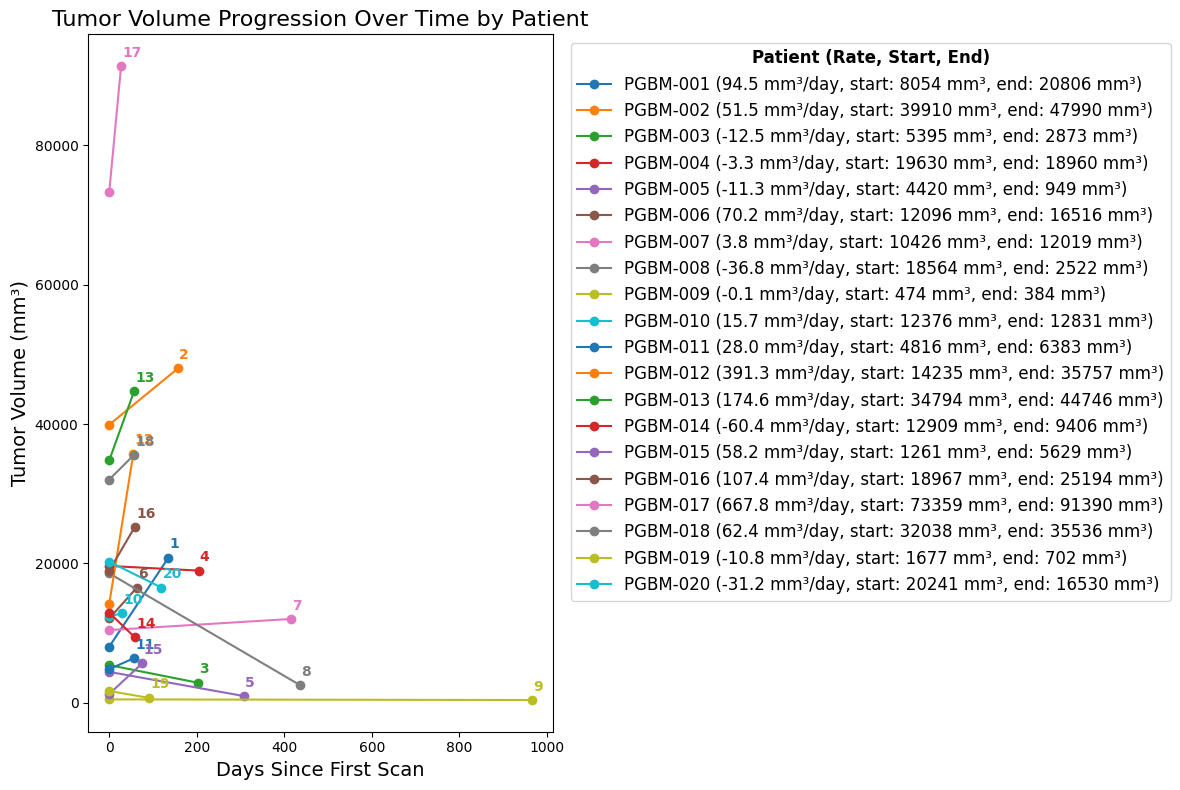

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from datetime import datetime

# ── 1) Path settings ──
preproc_root = "/mnt/ssd/brain-tumor-prediction/data/btp_preproc_fixed22"
reg_root     = "/mnt/ssd/brain-tumor-prediction/data/btp_reg_flirt_t1ce_fixed22_nostrip"

# ── 2) Collect per‐patient data ──
# patient_data[patient_id] = (days_list, volume_list, growth_rate)
patient_data = {}
for patient_id in sorted(os.listdir(reg_root)):
    p_reg = os.path.join(reg_root, patient_id)
    p_pre = os.path.join(preproc_root, patient_id)
    if not os.path.isdir(p_reg) or not os.path.isdir(p_pre):
        continue

    # Gather session dates
    sessions = []
    for d in os.listdir(p_pre):
        p_d = os.path.join(p_pre, d)
        if os.path.isdir(p_d):
            try:
                dt = datetime.strptime(d, "%Y-%m-%d")
                sessions.append((dt, d))
            except ValueError:
                pass
    if not sessions:
        continue

    sessions.sort(key=lambda x: x[0])
    first_date = sessions[0][0]

    days_list = []
    volume_list = []
    for dt, d in sessions:
        days_list.append((dt - first_date).days)
        mask_path = os.path.join(p_pre, d, "mask.nii.gz")
        if not os.path.exists(mask_path):
            volume_list.append(0.0)
            continue
        m_nii = nib.load(mask_path)
        data  = m_nii.get_fdata()
        # voxel size from registered mask if exists
        reg_mask = os.path.join(p_reg, d, "mask2fixed_affine.nii.gz")
        if os.path.exists(reg_mask):
            r_nii = nib.load(reg_mask)
            vx, vy, vz = r_nii.header.get_zooms()[:3]
        else:
            vx, vy, vz = m_nii.header.get_zooms()[:3]
        vol_per_voxel = vx * vy * vz
        volume_list.append(np.count_nonzero(data) * vol_per_voxel)

    # compute growth rate
    if len(days_list) > 1:
        tot_days = days_list[-1] - days_list[0]
        tot_vol  = volume_list[-1] - volume_list[0]
        rate     = tot_vol / tot_days if tot_days else 0.0
    else:
        rate = 0.0

    patient_data[patient_id] = (days_list, volume_list, rate)

# ── 3) Plot ──
plt.figure(figsize=(12, 8))

# 전체 부피 범위 계산 (annotation offset 용)
all_vols = np.hstack([vols for (_, (_, vols, _)) in patient_data.items()]) \
           if patient_data else np.array([0.])
vspan = all_vols.max() - all_vols.min() if all_vols.size>1 else 1.0

for idx, (pid, (days, vols, rate)) in enumerate(patient_data.items(), start=1):
    # initial & final volumes
    init_vol  = vols[0] if vols else 0.0
    final_vol = vols[-1] if vols else 0.0

    # label: include rate, start & end volumes
    label = (
        f"{pid} "
        f"({rate:.1f} mm³/day, "
        f"start: {init_vol:.0f} mm³, "
        f"end: {final_vol:.0f} mm³)"
    )

    # plot line and retrieve its color
    line_obj, = plt.plot(days, vols, marker='o', label=label)
    c = line_obj.get_color()

    # annotate each curve's last point with its index
    x_last, y_last = days[-1], vols[-1]
    plt.text(
        x_last + 3,
        y_last + 0.01 * vspan,
        str(idx),
        fontsize=10,
        fontweight='bold',
        color=c,
        ha='left',
        va='bottom'
    )

# axes labels and title
plt.xlabel("Days Since First Scan", fontsize=14)
plt.ylabel("Tumor Volume (mm³)",       fontsize=14)
plt.title("Tumor Volume Progression Over Time by Patient", fontsize=16)

# keep legend with full labels
legend = plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=12,
    title="Patient (Rate, Start, End)",
    title_fontsize=12
)
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()
